# Supervised Fine-Tuning (SFT) with LoRA/QLoRA using TRL — on a Free Colab Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/huggingface/cookbook/blob/main/notebooks/en/fine_tuning_llm_grpo_trl.ipynb)

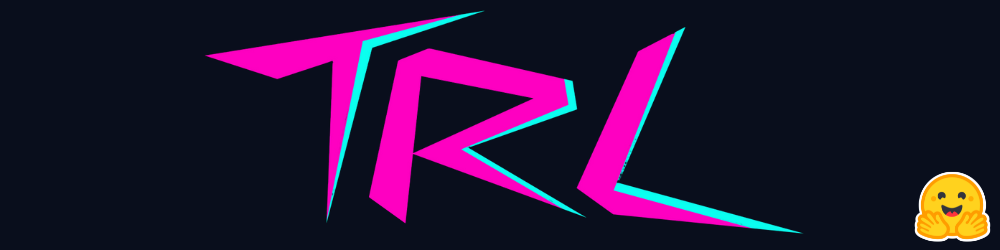

Easily fine-tune Large Language Models (LLMs) or Vision-Language Models (VLMs) with **LoRA** or **QLoRA** using the [**Transformers Reinforcement Learning (TRL)**](https://github.com/huggingface/trl) library built by Hugging Face — all within a **free Google Colab notebook** (powered by a **T4 GPU**.).  

- [TRL GitHub Repository](https://github.com/huggingface/trl) — star us to support the project!  
- [Official TRL Examples](https://huggingface.co/docs/trl/example_overview)  
- [Community Tutorials](https://huggingface.co/docs/trl/community_tutorials)

Learn how to perform **Supervised Fine-Tuning (SFT)** with **LoRA/QLoRA** using **TRL**.

## Install dependencies

We'll install **TRL**, which automatically includes the main dependencies such as **Transformers** and **PEFT**.
Additionally, we'll install **trackio** to log and monitor our experiments.

In [ ]:
!pip install -Uq trl trackio

### Log in to Hugging Face

Log in to your **Hugging Face** account to save your fine-tuned model, track your experiment results directly on the Hub or access gated models. You can find your **access token** on your [account settings page](https://huggingface.co/settings/tokens).

You can skip this cell and the next if you don’t want to save your model, although doing so may lead to unexpected behavior.








In [ ]:
from huggingface_hub import notebook_login

notebook_login()

We’ll retrieve your **Hugging Face username** to use it as part of the path for saving and loading the fine-tuned model.

In [ ]:
from huggingface_hub import HfApi

api = HfApi()
username = api.whoami()["name"]

If you're not logged in to Hugging Face, uncomment and run the cell below to avoid potential errors.

In [ ]:
# username = ""

## Load dataset

In this step, we load the **Capybara** dataset from the Hugging Face Hub using the `datasets` library.  
**Capybara** is a collection of high-quality, multi-turn synthetic conversations generated. It emphasizes reasoning, logic, and information diversity across a wide range of domains—making it ideal for training models capable of engaging in complex and natural dialogues.  

Here, we load only the **training split** for efficiency:

In [ ]:
from datasets import load_dataset

dataset_name = "trl-lib/Capybara"
train_dataset = load_dataset(dataset_name, split = "train")

## Load model and configure LoRA/QLoRA

There are two ways to use this notebook, depending on your chosen fine-tuning method:

- **Using QLoRA:** Run the following cell as is.  
- **Using LoRA:** Comment out the installation instruction and update the `use_qlora` parameter accordingly.

In [ ]:
# If using QLoRA
!pip install -Uq bitsandbytes

use_qlora = True
# use_qlora = False

Below, choose your **preferred model**. All of the options have been tested on **free Colab instances**.

In [ ]:
# --- 🔧 Model selection ---

# Select one model below by uncommenting the line you want to use 👇
# (Comments indicate memory usage or warnings)

# 🧠 LoRA models (explicitly LoRA)
## Qwen QLoRA
model_id, output_dir = "Qwen/Qwen3-0.6B", "Qwen3-0.6B-SFT"        # ✅ WORKS
model_id, output_dir = "Qwen/Qwen3-1.7B", "Qwen3-1.7B-SFT"        # ✅ WORKS

# 🧩 QLoRA models (default if not LoRA)
## Qwen QLoRA
# model_id, output_dir = "Qwen/Qwen2.5-0.5B-Instruct", "Qwen2.5-0.5B-Instruct"
# model_id, output_dir = "Qwen/Qwen3-4B", "Qwen3-4B-SFT"            # ✅ WORKS
# model_id, output_dir = "Qwen/Qwen3-8B", "Qwen3-8B-SFT"            # ⚠️ ~12.8 GB VRAM
# model_id, output_dir = "Qwen/Qwen3-14B", "Qwen3-14B-SFT"          # ❌ OOM


## LLaMA QLoRA
# model_id, output_dir = "meta-llama/Llama-3.1-8B-Instruct", "Llama-3.1-8B-Instruct"  # ⚠️ ~10.9 GB VRAM
# model_id, output_dir = "meta-llama/Llama-3.2-3B-Instruct", "Llama-3.2-3B-Instruct"  # ✅ ~4.7 GB VRAM

## DeepSeek QLoRA
# model_id, output_dir = "deepseek-ai/DeepSeek-R1-0528-Qwen3-8B", "DeepSeek-R1-0528-Qwen3-8B"

## Gemma QLoRA
# model_id, output_dir = "google/gemma-3n-E2B-it", "gemma-3n-E2B-it"  # ❌ OOM
# model_id, output_dir = "google/gemma-3-4b-it", "gemma-3-4b-it"      # ⚠️ image processing error

## Granite QLoRA
#model_id, output_dir = "ibm-granite/granite-4.0-micro", "granite-4.0-micro"  # ✅ ~3.3 GB VRAM

Let's lead the selected model using `transformers`, configuring QLoRA via `bitsandbytes` if needed. We don't need to configure the tokenizer since the trainer takes care of that automatically.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

kwargs = {
    "attn_implementation": "sdpa",  # Change to Flash Attention if GPU has support
    "dtype": torch.float16,          # Change to bfloat16 if GPU has support
    "use_cache": True,
    "max_length": 2048,
}

if use_qlora:
    kwargs["quantization_config"] = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4"
    )

model = AutoModelForCausalLM.from_pretrained(model_id, **kwargs)

The following cell defines LoRA (or QLoRA if needed).

In [ ]:
from peft import LoraConfig

peft_config = LoraConfig(
    r=32,
    lora_alpha=16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
)

## Train model

Let's configure SFT using `SFTConfig`. We keep the parameters minimal to fit in a free Colab instance. You can play with them if more resources are available.

In [ ]:
from trl import SFTConfig

training_args = SFTConfig(
    learning_rate=2e-4,
    num_train_epochs=1,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    warmup_steps=5,
    logging_steps=1,
    optim="adamw_8bit" if use_qlora else "adamw_torch",
    report_to="trackio",
    output_dir=output_dir,
)

Configure the SFT Trainer. We pass the previously configured `training_args`. We don't use eval dataset to mantain memory usage low but you can configure it.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    peft_config=peft_config
)

Show memory stats before training

In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

And train!

In [ ]:
trainer_stats = trainer.train()

Show memory stats after training

In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

## Saving fine tuned model

In this step, we save the fine-tuned model both **locally** and to the **Hugging Face Hub** using the credentials from your account.

In [ ]:
trainer.save_model(output_dir)
trainer.push_to_hub(f"{username}/{output_dir}", dataset_name=dataset_name)

## Load fine-tuned model and run inference

Now, let's test the fine-tuned model by loading the **LoRA/QLoRA adapter** and performing **inference**.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

base_model = model_id
adapter_model = f"{username}/{output_dir}" # if LoRA/QLoRA

model = AutoModelForCausalLM.from_pretrained(base_model, dtype="auto", device_map="auto")
model = PeftModel.from_pretrained(model, adapter_model) # if LoRA/QLoRA

tokenizer = AutoTokenizer.from_pretrained(base_model)

In [ ]:
messages = [
    {
        "role": "user",
        "content": "What is the capital of Spain?",
    },
]

In [ ]:
text = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=500
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

# Decode and extract model response
generated_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(generated_text)

## Inference and Serving with vLLM

You can use Transformer models with **vLLM** to serve them in real-world applications. Learn more [here](https://blog.vllm.ai/2025/04/11/transformers-backend.html).

In [ ]:
!pip install -qU vllm

### Push Merged Model (for LoRA or QLoRA Training)

To serve the model via **vLLM**, the repository must contain the merged model (base model + LoRA adapter). Therefore, you need to upload it first.

In [ ]:
model_merged = model.merge_and_unload()

save_dir = f"{output_dir}-merged"

model_merged.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

In [ ]:
model_merged.push_to_hub(f"{username}/{output_dir}-merged")
tokenizer.push_to_hub(f"{username}/{output_dir}-merged")

### Performing Inference with vLLM

Use **vLLM** to run your model and generate text efficiently in real-time. This allows you to test and deploy your fine-tuned models with low latency and high throughput.

In [ ]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

llm = LLM(model=f"{username}/{output_dir}-merged", model_impl="transformers")  # if LoRA/QLoRA
hf_tokenizer = AutoTokenizer.from_pretrained(f"{username}/{output_dir}-merged")  # if LoRA/QLoRA

messages = [
    {
        "role": "user",
        "content": "What is the capital of Spain?",
    },
]

prompt = hf_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

outputs = llm.generate(
    {"prompt": prompt},
    sampling_params=SamplingParams(max_tokens=500),
)

for o in outputs:
    generated_text = o.outputs[0].text
    print(generated_text)